We check the implementation of G2PnetSovler class in ../src/

Created by Tianpei Xie, 03/30/2016

Last Edit 03/30/2016

In [64]:
%reset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
import GPy
import GPy.util as gutil

%matplotlib inline 


plt.close('all')
Ifsavefig =  True  #False
Ifsavedata = False #True

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


The network generating

In [65]:
size = 40
color_map = {0:'r', 1:'c', 2:'y'}
#center = np.zeros(2)
#center[1] = 1
center = None

n = 40
m = 0
G0= nx.barbell_graph(n,m) 
#generate the bar-bell graph, which consists of two fully connected component and a path connecting them 

label0 = np.zeros([2*n,1])
label0[n:2*n] = np.ones([n,1])
#### labeling of the cluster
for node in G0.nodes():
    G0.node[node]['category'] = int(label0[node,0])

In [66]:
####generate the eigenspace of normalized Laplacian
k = 3
nnodes = nx.adjacency_matrix(G0).shape[0]

ncv=max(2*k+1,int(np.sqrt(nnodes)))

eigenvalues,eigenvectors= sp.sparse.linalg.eigsh(nx.laplacian_matrix(G0).asfptype(), k=k, \
                                                which='SM', return_eigenvectors = True, ncv=ncv)
index=np.argsort(eigenvalues)[1:k] # 0 index is zero eigenvalue    
pos_spectral_mat = np.real(eigenvectors[:,index]) #pos_spectral_mat is the spectral location of the nodes
pos_spectral_df = pd.DataFrame(data=pos_spectral_mat, columns=['PX','PY'], dtype=float)
pos_spectral_df['LABEL'] = label0

The node attributes generating

In [67]:
T= 2
c = 2*np.pi*0.8
data_np = np.zeros([nnodes, T])
column_name = []
for t in np.arange(1,T+1):
    temp1 = np.multiply(pos_spectral_df['PX'].apply(lambda x: np.exp(-c*t*x)).values, \
                          pos_spectral_df['PY'].apply(lambda y: np.cos(c*t*y)).values)
    data_np[:,t-1] = temp1
    if t == 1:
        column_name = str(t-1)+"_cos"
    else:    
        column_name = [column_name, str(t-1)+"_cos"]

sigma = 0.1        
data_np = np.add(data_np, sigma*np.random.randn(nnodes, T))    
data_df = pd.DataFrame(data=data_np, columns=column_name, dtype=float)
data_df['LABEL'] = label0

In [68]:
if Ifsavedata:
    nx.write_adjlist(G0, "../data/experiment_03_30_2016.adjlist",delimiter=',')
    nx.write_edgelist(G0, "../data/experiment_03_30_2016.edgelist")

    np.savez("../data/experiment_data_03_30_2016.npz", pos_spectral_mat, data_np, label0)
    data_df.to_csv("../data/experiment_X_03_30_2016.csv", index_label= 'ID')
    pos_spectral_df.to_csv("../data/experiment_U_03_30_2016.csv", index_label= 'ID')

In [69]:
X= data_np
U= pos_spectral_mat
nsample, ndim = X.shape
_ , ndim_latent = U.shape

kern = GPy.kern.RBF(2) 

Import from the G2PnetSolver_v1.py 

In [70]:
import sys
import os
dirorg = os.path.dirname(os.getcwd())
sys.path.insert(0, dirorg+"/src/")

In [71]:
import G2PnetSolver_v1
#from imp import reload
#reload(G2PnetSolver_v1)

In [72]:
from G2PnetSolver_v1 import  G2PnetSolver as Solver
from G2PnetSolver_v1 import  Grassmann_update

In [73]:
choice = "near"

In [74]:
np.random.seed(seed=121)

if choice == "random":
    print("Random")
    Temp = np.random.rand(nsample, nsample)
    Temp_sym = (Temp + Temp.T) / 2 
    _, U_temp = np.linalg.eig(Temp_sym)
    U_test = U_temp[:, np.arange(ndim_latent)]
    U0 = U_test
elif choice == "near":
    print("Near optimal.")
    U0 = U

eta0 = 1
G_temp = np.random.rand(nsample, ndim_latent)
H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(U0)),G_temp)
U_init = Grassmann_update(U0, H_temp, eta=eta0)

Near optimal.


In [75]:
if Ifsavedata:
    U_columns = [str(i) for i in np.arange(ndim_latent)]
    U_df = pd.DataFrame(data = U_init, columns=U_columns, dtype= float)
    if choice == "random":
        U_df['RANDOM'] = np.ones([nsample, 1])
    elif choice == "near":
        U_df['RANDOM'] = np.zeros([nsample, 1])
    
    U_df.to_csv("../data/U_init_03_30_16.csv")

In [76]:
eta = 0.0001
solver = Solver(X=X, U=U_init, kernel=kern, eta=eta)

Kernel initialization ...


In [77]:
max_iters = 1000
hist_nll_eu, hist_eta, hist_kern_eu = solver.optimize(max_iters = max_iters)

[step   0] neg-log-likelihood -877.770595 stepsize 0.000
The gradient of L w.r.t. U not been computed. Just compute it anyway.
The gradient of L w.r.t K not been computed. Just compute it anyway.
The gradient of K w.r.t. U not been computed. Just compute it anyway
[step   1] neg-log-likelihood -687.437537 stepsize 0.000
[step   2] neg-log-likelihood -485.102964 stepsize 0.000
[step   3] neg-log-likelihood -420.317371 stepsize 0.000
[step   4] neg-log-likelihood -420.216525 stepsize 0.000
[step   5] neg-log-likelihood -431.275049 stepsize 0.000
[step   6] neg-log-likelihood -443.101916 stepsize 0.000
[step   7] neg-log-likelihood -453.028176 stepsize 0.000
[step   8] neg-log-likelihood -461.237968 stepsize 0.000
[step   9] neg-log-likelihood -464.206023 stepsize 0.000
[step  10] neg-log-likelihood -466.594934 stepsize 0.000
[step  11] neg-log-likelihood -468.874152 stepsize 0.000
[step  12] neg-log-likelihood -470.804978 stepsize 0.000
[step  13] neg-log-likelihood -472.427979 stepsize 

In [78]:

solver2 = Solver(X=X, U=U_init, kernel=kern, eta=eta)
hist_nll_grass, hist_eta, hist_kern_grass = solver2.optimize(max_iters = max_iters, optimizor = "grad_descent_grass")

Kernel initialization ...
[step   0] neg-log-likelihood -878.789218 stepsize 0.000
The gradient of L w.r.t. U not been computed. Just compute it anyway.
The gradient of L w.r.t K not been computed. Just compute it anyway.
The gradient of K w.r.t. U not been computed. Just compute it anyway
[step   1] neg-log-likelihood -686.210108 stepsize 0.000
[step   2] neg-log-likelihood -483.624221 stepsize 0.000
[step   3] neg-log-likelihood -419.416310 stepsize 0.000
[step   4] neg-log-likelihood -419.109032 stepsize 0.000
[step   5] neg-log-likelihood -429.856211 stepsize 0.000
[step   6] neg-log-likelihood -441.379145 stepsize 0.000
[step   7] neg-log-likelihood -451.093849 stepsize 0.000
[step   8] neg-log-likelihood -459.378504 stepsize 0.000
[step   9] neg-log-likelihood -462.963798 stepsize 0.000
[step  10] neg-log-likelihood -464.947678 stepsize 0.000
[step  11] neg-log-likelihood -467.094829 stepsize 0.000
[step  12] neg-log-likelihood -469.009881 stepsize 0.000
[step  13] neg-log-likeli

In [79]:
trail = 5

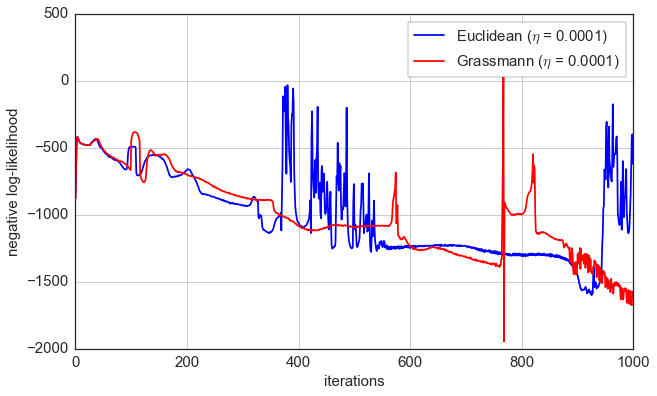

In [80]:
fig= plt.figure(4)
fig.set_size_inches(10.0, 6.0)
plt.style.use('seaborn-white')
ax = plt.axes()
h1, = plt.plot(np.arange(max_iters), hist_nll_eu, 'b')
h2, = plt.plot(np.arange(max_iters), hist_nll_grass, 'r')
ax.legend([h1, h2], [r"Euclidean ($\eta$ = {0:5.4f})".format(eta), r"Grassmann ($\eta$ = {0:5.4f})".format(eta)], \
          fontsize = 15, loc='upper right', frameon=True)
plt.grid(1)
plt.ylabel('negative log-likelihood', fontsize = 15)
plt.xlabel('iterations', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show
if Ifsavefig:
    file_org = "../figures/nll_iters_Grass_Eu_" + str(trail) + "_"
    file_tail = "_03_30_16.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
    fig.savefig(file_org + file_comment + file_tail )

In [81]:
%xdel solver
%xdel solver2